# Airline Passengers Forecasting

# 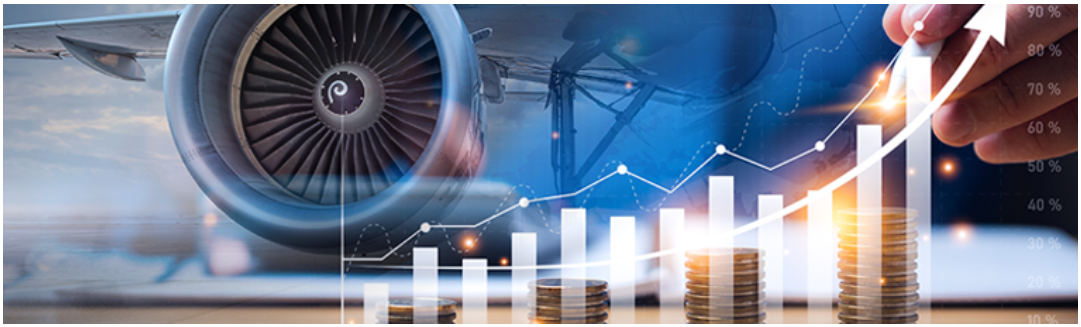

## Problem Statement :
#### The airline industry is highly dynamic, with passenger demand fluctuating based on various factors such as seasonality, holidays, and economic conditions. Accurate forecasting of airline passenger numbers is crucial for optimizing resources, managing schedules, and ensuring a seamless travel experience for passengers. The goal of this project is to develop a robust time series forecasting model to predict future airline passenger counts based on historical data.

## Importing Libraries

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")

from numpy import log
from pandas import Series
from datetime import datetime

## Importing Dataset

In [2]:
dataset = pd.read_csv("airline_passengers.csv")

In [3]:
dataset.head()

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
dataset.tail()

,Month,Thousands of Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


## Cheking Missing Values

In [5]:
dataset.isnull().sum()

Month                      0
Thousands of Passengers    0
dtype: int64

- No Missing Data found.

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Month                    144 non-null    object
 1   Thousands of Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


- Observation - Month is coming as object but it is a datetime variable. So convert it into datetime format.

## Datetime Format Conversion

In [7]:
dataset["Month"] = pd.to_datetime(dataset["Month"])

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    144 non-null    datetime64[ns]
 1   Thousands of Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [9]:
dataset.head() 
# Here bydefault date will come "01" because in original dataset there is just month(mm) and year(yyyy) but not date(dd).

,Month,Thousands of Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


## Setting Month(datetime) variable as index

In [10]:
# Make the datetime variable as index because we have to analyze the "Thousands of Passengers" based on the time only.
# Remove bydefault system generated index and consider Month(datetime) variable as index value.

In [11]:
dataset.set_index("Month", inplace = True)

In [12]:
dataset.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Plot the Dataset

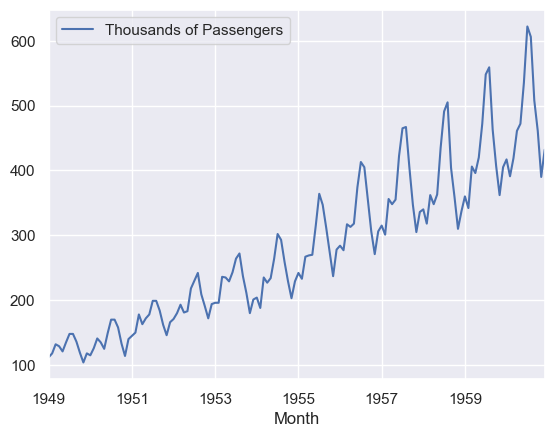

In [13]:
dataset.plot()
plt.show()

- The plot depicts the upward trend (we have data for 12 years).
- Also, there is seasonality (As there are peak points every year).

## Decomposition

In [14]:
# Decomposition to check dataset pattern/component.

from statsmodels.tsa.seasonal import seasonal_decompose

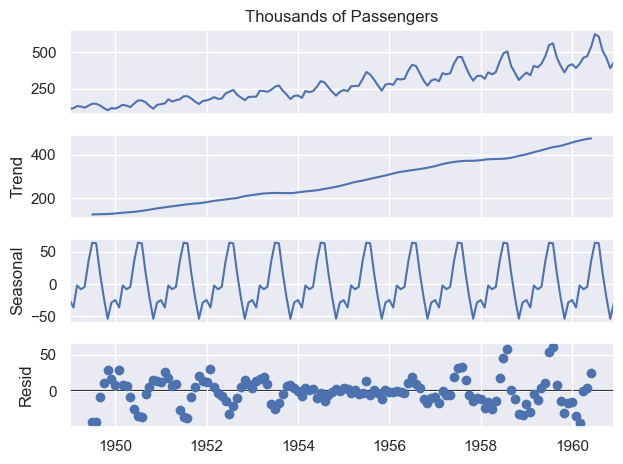

In [15]:
decomposition = seasonal_decompose(dataset["Thousands of Passengers"], model = "additive", period = 12)
decomposition.plot()
plt.show()

- This dataset is having both Trend and Seasonality as shown by the Decomposition graph.

## Autocorrelation Verification - Durbin Watson Test

In [16]:
# Check Whether Autocorrelation is there in the dataset or not by DURBIN WATSON TEST(DWT)

import statsmodels.api as sm

In [17]:
sm.stats.durbin_watson(dataset["Thousands of Passengers"])

0.0121527966037621

- DWT value = 2 --> No Autocorrelation
- DWT value is between 0 to 2 ---> Positive Autocorrelation
- DWT value is between 2 to 4 ---> Negative Autocorrelation
- Here DWT value(0.0121) is less than 2. So, definitely there is Autocorrelation(positive) and need to solve this problem by Time Series Forecasting and not by Linear Regression.

## Verifying Stationarity of Dataset - Augmented Dickey Fuller Test

In [18]:
# Check stationarity of dataset by ---> AUGMENTED DICKEY FULLER TEST.

from statsmodels.tsa.stattools import adfuller

In [19]:
adfuller(dataset["Thousands of Passengers"])

(0.8153688792060482,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [20]:
def adf_verify(timeseries_dataset):
    result = adfuller(timeseries_dataset)
    print("******************** Augmented Dickey Fuller Test ********************")
    labels = ["ADF Stats Test", "p-value", "Lags", "No.of Observation"]
    
    for r, l in zip(result, labels):
        print(l + " : " + str(r))
        
    if result[1] <= 0.05:
        print("Found Strong evidence against null hypothesis and my Time Series is Stationary.")
    else:
        print("Found Week evidence against null hypothesis and my Time Series is Non-Stationary.")

In [21]:
adf_verify(dataset["Thousands of Passengers"])

******************** Augmented Dickey Fuller Test ********************
ADF Stats Test : 0.8153688792060482
p-value : 0.991880243437641
Lags : 13
No.of Observation : 130
Found Week evidence against null hypothesis and my Time Series is Non-Stationary.


- Here, p-value > 0.05 so we have to calculate the 1st difference value.

### Calculate 1st Difference (Trend)

In [22]:
dataset["1st Difference"] = dataset["Thousands of Passengers"] - dataset["Thousands of Passengers"].shift(1)

In [23]:
dataset.head()

,Thousands of Passengers,1st Difference
Month,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


In [24]:
adf_verify(dataset["1st Difference"].dropna())

******************** Augmented Dickey Fuller Test ********************
ADF Stats Test : -2.8292668241699994
p-value : 0.0542132902838255
Lags : 12
No.of Observation : 130
Found Week evidence against null hypothesis and my Time Series is Non-Stationary.


- Here again the p-value is not less than 0.05 so we have to take the second difference value.

### Calculate 2nd Difference (Trend)

In [25]:
dataset["2nd Difference"] = dataset["1st Difference"] - dataset["1st Difference"].shift(1)

In [26]:
dataset.head()

,Thousands of Passengers,1st Difference,2nd Difference
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,8.0
1949-04-01,129,-3.0,-17.0
1949-05-01,121,-8.0,-5.0


In [27]:
adf_verify(dataset["2nd Difference"].dropna())

******************** Augmented Dickey Fuller Test ********************
ADF Stats Test : -16.384231542468505
p-value : 2.7328918500142407e-29
Lags : 11
No.of Observation : 130
Found Strong evidence against null hypothesis and my Time Series is Stationary.


- Now that our Time Series is Stationary we will stop here the calculation of difference(d) for Trend.
- As after 2nd difference our dataset is stationary. so, **d=2 for trend**.
- As there is seasonality also in our dataset so we will also calculate the difference(D) for seasonality.

### Difference Calculation for Seasonality

### Calculate 1st Difference 

In [28]:
dataset["seasonality"] = dataset["Thousands of Passengers"] - dataset["Thousands of Passengers"].shift(12)

In [29]:
dataset.head(15)

,Thousands of Passengers,1st Difference,2nd Difference,seasonality
Month,,,,
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN
1949-03-01,132,14.0,8.0,NaN
1949-04-01,129,-3.0,-17.0,NaN
1949-05-01,121,-8.0,-5.0,NaN
1949-06-01,135,14.0,22.0,NaN
1949-07-01,148,13.0,-1.0,NaN
1949-08-01,148,0.0,-13.0,NaN
1949-09-01,136,-12.0,-12.0,NaN


In [30]:
adf_verify(dataset["seasonality"].dropna())

******************** Augmented Dickey Fuller Test ********************
ADF Stats Test : -3.383020726492481
p-value : 0.011551493085514952
Lags : 1
No.of Observation : 130
Found Strong evidence against null hypothesis and my Time Series is Stationary.


- Here, after 1st difference our dataset is stationary. so, **D=1** for seasonality.

## Calculating Autocorrelation(Q/q) & Partial Autocorrelation(P/p) 

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Partial Autocorrelation(p) For Trend 

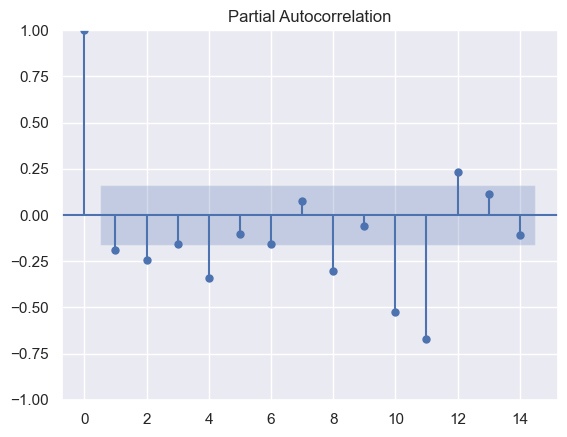

In [32]:
plot_pacf(dataset["2nd Difference"].dropna(), lags = 14) 
"""
We are checking Partial Autocorrelation on "2nd Difference" variable because now, that is our stationary variable derived
from original variable "Thousands of Passengers"
Here lags=14 is months. We are keeping lags=14 i.e more than one year(12 months) because we are calculating for trend.
"""
plt.show()

- Here **p = 4**.

### Autocorrelation(q) for Trend

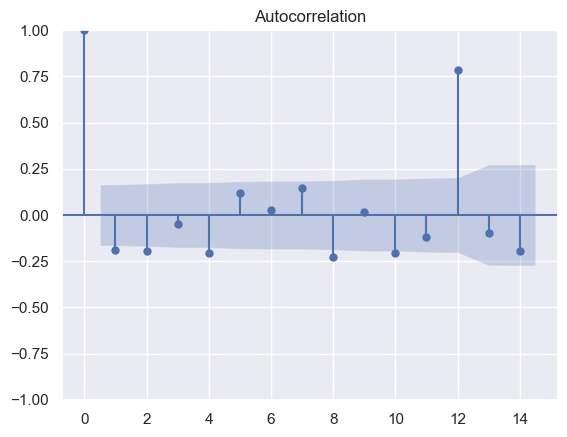

In [33]:
plot_acf(dataset["2nd Difference"].dropna(), lags = 14)
plt.show()

- Here, **q = 2**.
- For Trend, **p=4**, **d=2**, **q=2**

### Partial Autocorrelation(P) for Seasonality

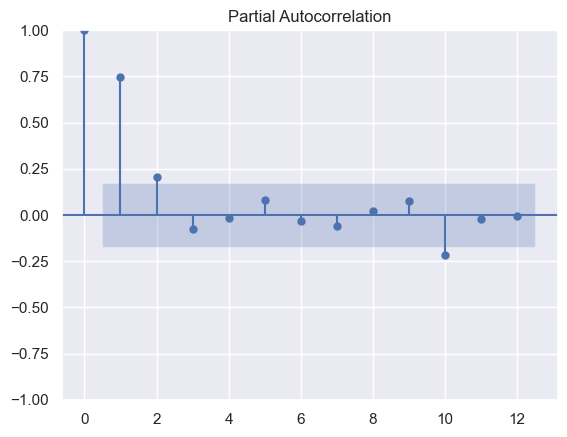

In [34]:
plot_pacf(dataset["seasonality"].dropna(), lags = 12)
plt.show()

- Here, **P=2**.

### Autocorrelation(Q) for Seasonality

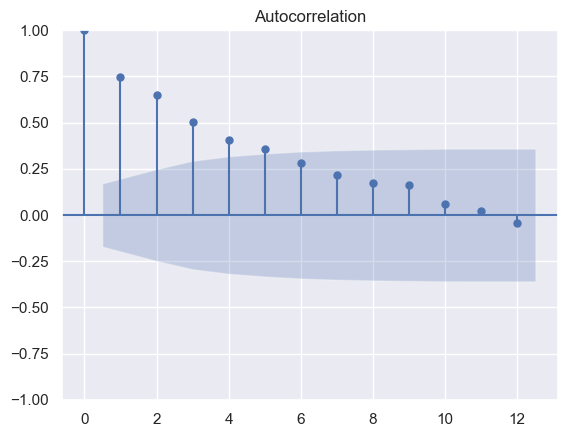

In [35]:
plot_acf(dataset["seasonality"].dropna(), lags = 12)
plt.show()

- Here, **Q=5**.
- For Seasonality, **P=2**, **D=1**, **Q=5**.

# ARIMA Model

In [36]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

#### Trend ---> p = 4, d = 2, q = 2
#### Seasonality ---> P = 2, D = 1, Q = 5

In [37]:
model = sm.tsa.statespace.SARIMAX(dataset["Thousands of Passengers"], order = (4,2,2), seasonal_order = (2,1,5,12))

C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [38]:
result = model.fit()

C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [39]:
print(result.summary())

                                            SARIMAX Results                                             
Dep. Variable:                          Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1, 2, 3, 4, 5], 12)   Log Likelihood                -496.725
Date:                                          Tue, 12 Dec 2023   AIC                           1021.451
Time:                                                  16:19:46   BIC                           1061.596
Sample:                                              01-01-1949   HQIC                          1037.763
                                                   - 12-01-1960                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar

- Here, the SARIMAX Model is giving **AIC = 1021.451 for Q = 5**.
- Also, the **model is suggesting 5 different values(1,2,3,4,5) for Q**. So, we will **one by one build the the model on that 5 different Q values** and observe their respective AIC value.
- The model for which the Q value is giving less AIC value we will choose that particular Q value and build the model.

#### SARIMAX Model (Q = 4)

In [40]:
model1 = sm.tsa.statespace.SARIMAX(dataset["Thousands of Passengers"], order = (4,2,2), seasonal_order = (2,1,4,12))
result1 = model1.fit()
print(result1.summary())

C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                           SARIMAX Results                                           
Dep. Variable:                       Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1, 2, 3, 4], 12)   Log Likelihood                -497.019
Date:                                       Tue, 12 Dec 2023   AIC                           1020.038
Time:                                               16:20:04   BIC                           1057.316
Sample:                                           01-01-1949   HQIC                          1035.185
                                                - 12-01-1960                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3740     

- Here, for **Q = 4** ---> **AIC value = 1020.038**.

#### SARIMAX Model (Q = 3)

In [41]:
model2 = sm.tsa.statespace.SARIMAX(dataset["Thousands of Passengers"], order = (4,2,2), seasonal_order = (2,1,3,12))
result2 = model2.fit()
print(result2.summary())

C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                         SARIMAX Results                                          
Dep. Variable:                    Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1, 2, 3], 12)   Log Likelihood                -497.177
Date:                                    Tue, 12 Dec 2023   AIC                           1018.354
Time:                                            16:20:23   BIC                           1052.764
Sample:                                        01-01-1949   HQIC                          1032.336
                                             - 12-01-1960                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3694      0.098    -14.014      0

- Here, for **Q = 3** ---> **AIC value = 1018.354**.

#### SARIMAX Model (Q = 2)

In [42]:
model3 = sm.tsa.statespace.SARIMAX(dataset["Thousands of Passengers"], order = (4,2,2), seasonal_order = (2,1,2,12))
result3 = model3.fit()
print(result3.summary())

C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:            Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, 2, 12)   Log Likelihood                -497.783
Date:                            Tue, 12 Dec 2023   AIC                           1017.565
Time:                                    16:20:30   BIC                           1049.108
Sample:                                01-01-1949   HQIC                          1030.382
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3578      0.099    -13.696      0.000      -1.552      -1.163
ar.L2         -0.4919      0.145   

- Here, for **Q = 2** ---> **AIC value = 1017.565**.

#### SARIMAX Model (Q = 1)

In [43]:
model4 = sm.tsa.statespace.SARIMAX(dataset["Thousands of Passengers"], order = (4,2,2), seasonal_order = (2,1,1,12))
result4 = model4.fit()
print(result4.summary())

C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:              Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1], 12)   Log Likelihood                -497.782
Date:                              Tue, 12 Dec 2023   AIC                           1015.563
Time:                                      16:20:36   BIC                           1044.239
Sample:                                  01-01-1949   HQIC                          1027.215
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3590      0.097    -14.021      0.000      -1.549      -1.169
ar.L2         -0.49

- Here, for **Q = 1** ---> **AIC value = 1015.563**.

- SARIMAX(4, 2, 2)x(2, 1, **5**, 12) : AIC - 1021.451 ------>for **Q = 5**
- SARIMAX(4, 2, 2)x(2, 1, **4**, 12) : AIC - 1020.038 ------>for **Q = 4**
- SARIMAX(4, 2, 2)x(2, 1, **3**, 12) : AIC - 1018.354 ------>for **Q = 3**
- SARIMAX(4, 2, 2)x(2, 1, **2**, 12) : AIC - 1017.565 ------>for **Q = 2**
- SARIMAX(4, 2, 2)x(2, 1, **1**, 12) : AIC - 1015.563 ------>for **Q = 1**

- So, here **SARIMAX model with Q = 1 is giving best result as its AIC value is lesser** as compare to all that of others.

## Forecasting the existing data before predicting the future time(Next 5 Years).

- In our dataset we have total 12 years(1949 to 1960) data i.e 144 months. 
- Here, we are predicting the existing data from 130th month to 144th month.

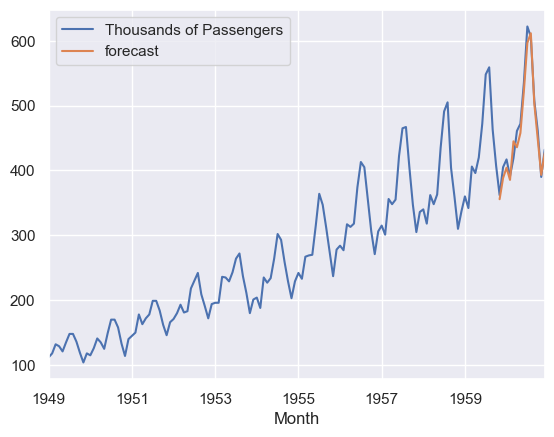

In [44]:
dataset["forecast"] = result4.predict(start=130, end=144, dynamic=True)
dataset[["Thousands of Passengers", "forecast"]].plot()
plt.show()

- As per the graph its clear that the model's prediction is matching the existing data.
- Now we can predict the passengers for the next 5 years.

## Next 5 Years Prediction (1961 to 1965)

In [45]:
dataset.tail()

,Thousands of Passengers,1st Difference,2nd Difference,seasonality,forecast
Month,,,,,
1960-08-01,606,-16.0,-103.0,47.0,611.542122
1960-09-01,508,-98.0,-82.0,45.0,503.488076
1960-10-01,461,-47.0,51.0,54.0,448.487488
1960-11-01,390,-71.0,-24.0,28.0,393.213074
1960-12-01,432,42.0,113.0,27.0,426.515996


- In our dataset we have data till year 1960. So, now we have to create dates for next 5 years to predict from 1961 to 1965.

### Creating Future 5 Years Dates. 

In [46]:
from pandas.tseries.offsets import DateOffset

In [47]:
future_dates = [dataset.index[-1] + DateOffset(months=x) for x in range(61)]

In [48]:
future_dates

[Timestamp('1960-12-01 00:00:00'),
 Timestamp('1961-01-01 00:00:00'),
 Timestamp('1961-02-01 00:00:00'),
 Timestamp('1961-03-01 00:00:00'),
 Timestamp('1961-04-01 00:00:00'),
 Timestamp('1961-05-01 00:00:00'),
 Timestamp('1961-06-01 00:00:00'),
 Timestamp('1961-07-01 00:00:00'),
 Timestamp('1961-08-01 00:00:00'),
 Timestamp('1961-09-01 00:00:00'),
 Timestamp('1961-10-01 00:00:00'),
 Timestamp('1961-11-01 00:00:00'),
 Timestamp('1961-12-01 00:00:00'),
 Timestamp('1962-01-01 00:00:00'),
 Timestamp('1962-02-01 00:00:00'),
 Timestamp('1962-03-01 00:00:00'),
 Timestamp('1962-04-01 00:00:00'),
 Timestamp('1962-05-01 00:00:00'),
 Timestamp('1962-06-01 00:00:00'),
 Timestamp('1962-07-01 00:00:00'),
 Timestamp('1962-08-01 00:00:00'),
 Timestamp('1962-09-01 00:00:00'),
 Timestamp('1962-10-01 00:00:00'),
 Timestamp('1962-11-01 00:00:00'),
 Timestamp('1962-12-01 00:00:00'),
 Timestamp('1963-01-01 00:00:00'),
 Timestamp('1963-02-01 00:00:00'),
 Timestamp('1963-03-01 00:00:00'),
 Timestamp('1963-04-

In [49]:
# Converting future_dates into DataFrame

future_dates_df = pd.DataFrame(index = future_dates[1:], columns = dataset.columns)

In [50]:
future_dates_df

,Thousands of Passengers,1st Difference,2nd Difference,seasonality,forecast
1961-01-01,NaN,NaN,NaN,NaN,NaN
1961-02-01,NaN,NaN,NaN,NaN,NaN
1961-03-01,NaN,NaN,NaN,NaN,NaN
1961-04-01,NaN,NaN,NaN,NaN,NaN
1961-05-01,NaN,NaN,NaN,NaN,NaN
1961-06-01,NaN,NaN,NaN,NaN,NaN
1961-07-01,NaN,NaN,NaN,NaN,NaN
1961-08-01,NaN,NaN,NaN,NaN,NaN
1961-09-01,NaN,NaN,NaN,NaN,NaN
1961-10-01,NaN,NaN,NaN,NaN,NaN


In [51]:
# Concatenate both the table (original table "dataset" and forecast table "future_dates_df")

future_df = pd.concat([dataset, future_dates_df], axis=0)

In [52]:
future_df.head()

,Thousands of Passengers,1st Difference,2nd Difference,seasonality,forecast
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN,NaN
1949-03-01,132,14.0,8.0,NaN,NaN
1949-04-01,129,-3.0,-17.0,NaN,NaN
1949-05-01,121,-8.0,-5.0,NaN,NaN


In [53]:
future_df.tail()

,Thousands of Passengers,1st Difference,2nd Difference,seasonality,forecast
1965-08-01,NaN,NaN,NaN,NaN,NaN
1965-09-01,NaN,NaN,NaN,NaN,NaN
1965-10-01,NaN,NaN,NaN,NaN,NaN
1965-11-01,NaN,NaN,NaN,NaN,NaN
1965-12-01,NaN,NaN,NaN,NaN,NaN


### 5 Years Prediction Graph from 1961 to 1965.

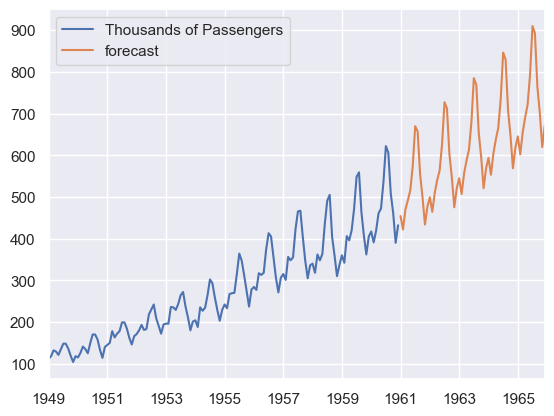

In [54]:
# 5 Years Prediction Graph from 1961 to 1965.

future_df["forecast"] = result4.predict(start=144, end=204, dynamic=True)
future_df[["Thousands of Passengers", "forecast"]].plot()
plt.show()

In [55]:
future_df.tail(60)

,Thousands of Passengers,1st Difference,2nd Difference,seasonality,forecast
1961-01-01,NaN,NaN,NaN,NaN,454.088311
1961-02-01,NaN,NaN,NaN,NaN,421.779176
1961-03-01,NaN,NaN,NaN,NaN,469.951452
1961-04-01,NaN,NaN,NaN,NaN,492.200156
1961-05-01,NaN,NaN,NaN,NaN,515.950333
1961-06-01,NaN,NaN,NaN,NaN,574.221967
1961-07-01,NaN,NaN,NaN,NaN,669.664313
1961-08-01,NaN,NaN,NaN,NaN,657.124879
1961-09-01,NaN,NaN,NaN,NaN,554.723387
1961-10-01,NaN,NaN,NaN,NaN,499.201343


## Export the Forecasted Data

In [56]:
future_df.to_csv("Final_Airline_Passengers_Details_For_5Years.csv")

# Facebook Prophet Model

In [57]:
import prophet

In [58]:
data = pd.read_csv("airline_passengers.csv")

### Renaming Month(Date) Variable as "ds" & Target as "y"

In [59]:
df_prophet = data.rename(columns = {"Month":"ds", "Thousands of Passengers":"y"})

In [60]:
df_prophet

,ds,y
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


### Model Fitting

In [61]:
from prophet import Prophet

In [62]:
m = Prophet()
model = m.fit(df_prophet)

16:20:39 - cmdstanpy - INFO - Chain [1] start processing
16:20:39 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
model.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

### Creating Future Dataframe to predict

- In our dataset we have data till year 1960. So, now we have to create dates for next 5 years to predict from 1961 to 1965.

In [64]:
future_pred = model.make_future_dataframe(periods = 61, freq = "M")

In [65]:
future_pred.tail(60)

,ds
145,1961-01-31
146,1961-02-28
147,1961-03-31
148,1961-04-30
149,1961-05-31
150,1961-06-30
151,1961-07-31
152,1961-08-31
153,1961-09-30
154,1961-10-31


## Predicting Future Forecasting

In [66]:
prediction = model.predict(future_pred)

In [67]:
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-01-01,106.662426,56.706850,114.189395,106.662426,106.662426,-21.848267,-21.848267,-21.848267,-21.848267,-21.848267,-21.848267,0.0,0.0,0.0,84.814159
1,1949-02-01,108.835452,49.320568,108.228975,108.835452,108.835452,-30.607522,-30.607522,-30.607522,-30.607522,-30.607522,-30.607522,0.0,0.0,0.0,78.227931
2,1949-03-01,110.798186,79.276623,138.431032,110.798186,110.798186,-0.455949,-0.455949,-0.455949,-0.455949,-0.455949,-0.455949,0.0,0.0,0.0,110.342237
3,1949-04-01,112.971212,77.537202,134.883392,112.971212,112.971212,-5.160494,-5.160494,-5.160494,-5.160494,-5.160494,-5.160494,0.0,0.0,0.0,107.810718
4,1949-05-01,115.074141,81.898622,138.567645,115.074141,115.074141,-3.807887,-3.807887,-3.807887,-3.807887,-3.807887,-3.807887,0.0,0.0,0.0,111.266255


In [68]:
prediction[["ds", "yhat", "yhat_lower", "yhat_upper"]]

,ds,yhat,yhat_lower,yhat_upper
0,1949-01-01,84.814159,56.706850,114.189395
1,1949-02-01,78.227931,49.320568,108.228975
2,1949-03-01,110.342237,79.276623,138.431032
3,1949-04-01,107.810718,77.537202,134.883392
4,1949-05-01,111.266255,81.898622,138.567645
...,...,...,...,...
200,1965-08-31,676.247240,646.707752,706.660689
201,1965-09-30,639.431867,608.842495,668.994914
202,1965-10-31,609.386652,581.274483,638.660750
203,1965-11-30,639.042990,610.251030,668.456291


## Plotting The Model

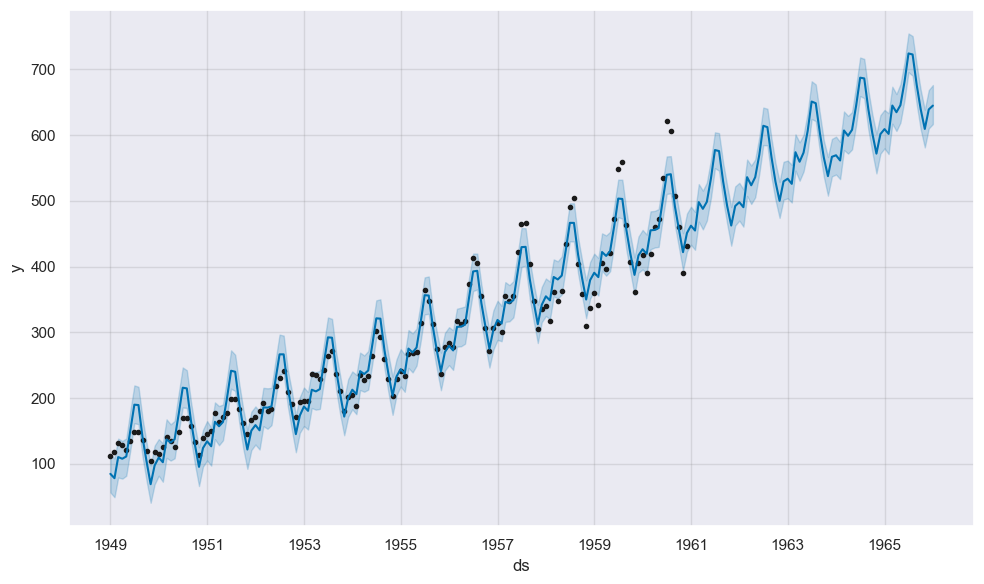

In [69]:
model.plot(prediction)
plt.show()

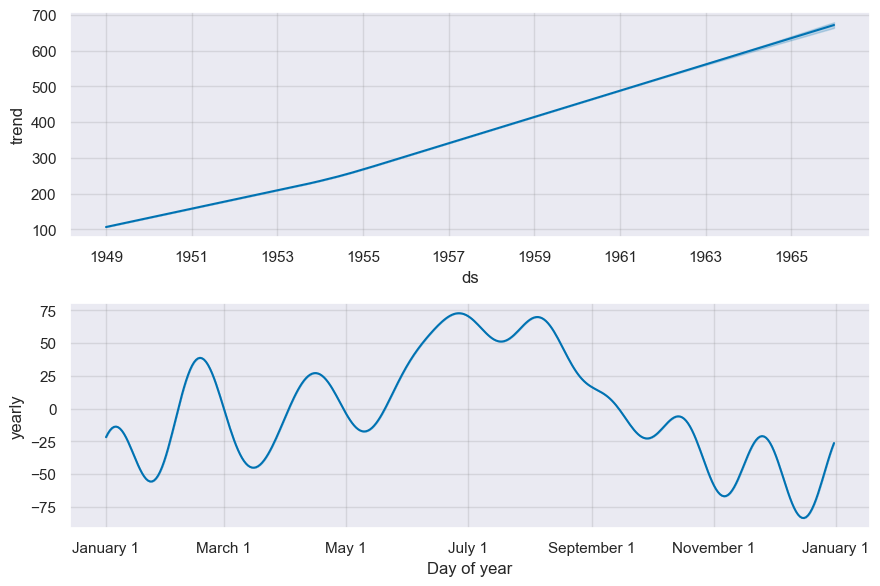

In [70]:
model.plot_components(prediction)
plt.show()

- The graph shows that there would be more number of passengers from Mid-June to August.

## Evaluation - Cross Validation and Performance Matirx

### Cross-Validation

In [71]:
from prophet.diagnostics import cross_validation

In [72]:
df_cv = cross_validation(model, horizon = "30 days", period = "15 days", initial = "90 days")

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/273 [00:00<?, ?it/s]

16:20:45 - cmdstanpy - INFO - Chain [1] start processing
16:20:46 - cmdstanpy - INFO - Chain [1] done processing
16:20:46 - cmdstanpy - INFO - Chain [1] start processing
16:20:46 - cmdstanpy - INFO - Chain [1] done processing
16:20:47 - cmdstanpy - INFO - Chain [1] start processing
16:20:49 - cmdstanpy - INFO - Chain [1] done processing
16:20:49 - cmdstanpy - INFO - Chain [1] start processing
16:20:51 - cmdstanpy - INFO - Chain [1] done processing
16:20:51 - cmdstanpy - INFO - Chain [1] start processing
16:20:52 - cmdstanpy - INFO - Chain [1] done processing
16:20:52 - cmdstanpy - INFO - Chain [1] start processing
16:20:53 - cmdstanpy - INFO - Chain [1] done processing
16:20:53 - cmdstanpy - INFO - Chain [1] start processing
16:21:14 - cmdstanpy - INFO - Chain [1] done processing
16:21:15 - cmdstanpy - INFO - Chain [1] start processing
16:21:15 - cmdstanpy - INFO - Chain [1] done processing
16:21:15 - cmdstanpy - INFO - Chain [1] start processing
16:21:16 - cmdstanpy - INFO - Chain [1]

16:31:37 - cmdstanpy - INFO - Chain [1] done processing
16:31:37 - cmdstanpy - INFO - Chain [1] start processing
16:31:38 - cmdstanpy - INFO - Chain [1] done processing
16:31:38 - cmdstanpy - INFO - Chain [1] start processing
16:31:39 - cmdstanpy - INFO - Chain [1] done processing
16:31:39 - cmdstanpy - INFO - Chain [1] start processing
16:31:40 - cmdstanpy - INFO - Chain [1] done processing
16:31:40 - cmdstanpy - INFO - Chain [1] start processing
16:31:41 - cmdstanpy - INFO - Chain [1] done processing
16:31:41 - cmdstanpy - INFO - Chain [1] start processing
16:31:42 - cmdstanpy - INFO - Chain [1] done processing
16:31:42 - cmdstanpy - INFO - Chain [1] start processing
16:31:43 - cmdstanpy - INFO - Chain [1] done processing
16:31:43 - cmdstanpy - INFO - Chain [1] start processing
16:31:44 - cmdstanpy - INFO - Chain [1] done processing
16:31:44 - cmdstanpy - INFO - Chain [1] start processing
16:31:45 - cmdstanpy - INFO - Chain [1] done processing
16:31:45 - cmdstanpy - INFO - Chain [1] 

16:32:50 - cmdstanpy - INFO - Chain [1] done processing
16:32:50 - cmdstanpy - INFO - Chain [1] start processing
16:32:51 - cmdstanpy - INFO - Chain [1] done processing
16:32:51 - cmdstanpy - INFO - Chain [1] start processing
16:32:52 - cmdstanpy - INFO - Chain [1] done processing
16:32:53 - cmdstanpy - INFO - Chain [1] start processing
16:32:54 - cmdstanpy - INFO - Chain [1] done processing
16:32:54 - cmdstanpy - INFO - Chain [1] start processing
16:32:54 - cmdstanpy - INFO - Chain [1] done processing
16:32:55 - cmdstanpy - INFO - Chain [1] start processing
16:32:55 - cmdstanpy - INFO - Chain [1] done processing
16:32:56 - cmdstanpy - INFO - Chain [1] start processing
16:32:57 - cmdstanpy - INFO - Chain [1] done processing
16:32:57 - cmdstanpy - INFO - Chain [1] start processing
16:32:58 - cmdstanpy - INFO - Chain [1] done processing
16:32:58 - cmdstanpy - INFO - Chain [1] start processing
16:32:59 - cmdstanpy - INFO - Chain [1] done processing
16:32:59 - cmdstanpy - INFO - Chain [1] 

16:33:56 - cmdstanpy - INFO - Chain [1] done processing
16:33:57 - cmdstanpy - INFO - Chain [1] start processing
16:33:57 - cmdstanpy - INFO - Chain [1] done processing
16:33:57 - cmdstanpy - INFO - Chain [1] start processing
16:33:57 - cmdstanpy - INFO - Chain [1] done processing
16:33:57 - cmdstanpy - INFO - Chain [1] start processing
16:33:57 - cmdstanpy - INFO - Chain [1] done processing
16:33:58 - cmdstanpy - INFO - Chain [1] start processing
16:33:58 - cmdstanpy - INFO - Chain [1] done processing
16:33:58 - cmdstanpy - INFO - Chain [1] start processing
16:33:58 - cmdstanpy - INFO - Chain [1] done processing
16:33:58 - cmdstanpy - INFO - Chain [1] start processing
16:33:59 - cmdstanpy - INFO - Chain [1] done processing
16:33:59 - cmdstanpy - INFO - Chain [1] start processing
16:33:59 - cmdstanpy - INFO - Chain [1] done processing
16:33:59 - cmdstanpy - INFO - Chain [1] start processing
16:33:59 - cmdstanpy - INFO - Chain [1] done processing
16:34:00 - cmdstanpy - INFO - Chain [1] 

In [73]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1949-05-01,-348.414894,-348.414894,-348.414894,121,1949-04-03
1,1949-05-01,-348.414894,-348.414894,-348.414894,121,1949-04-18
2,1949-06-01,-1467.853516,-1467.853516,-1467.853516,135,1949-05-03
3,1949-06-01,-1467.853516,-1467.853516,-1467.853516,135,1949-05-18
4,1949-07-01,-216.931835,-216.931836,-216.931835,148,1949-06-02
...,...,...,...,...,...,...
269,1960-10-01,458.403678,430.604260,485.784391,461,1960-09-02
270,1960-10-01,458.403678,428.985905,486.709813,461,1960-09-17
271,1960-11-01,430.059193,403.397219,460.506635,390,1960-10-02
272,1960-11-01,430.059193,401.707237,459.929237,390,1960-10-17


## Performance Metrics

In [74]:
from prophet.diagnostics import performance_metrics

In [75]:
df_performance = performance_metrics(df_cv)

In [76]:
df_performance

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,1.071515e+05,327.340061,101.777845,0.813749,0.071020,0.276894,0.305556
1,5 days,7.989340e+03,89.383110,30.225012,0.193079,0.047965,0.139257,0.400000
2,6 days,1.646944e+03,40.582552,28.021077,0.123659,0.083838,0.161583,0.313131
3,7 days,1.802503e+03,42.455894,29.979020,0.128677,0.086624,0.167015,0.242424
4,8 days,1.806463e+03,42.502505,30.775642,0.135107,0.087288,0.173509,0.192593
5,9 days,5.427415e+02,23.296812,18.299898,0.076085,0.070605,0.074580,0.333333
6,10 days,4.219005e+02,20.540216,16.934835,0.067512,0.063442,0.065859,0.400000
7,11 days,5.959599e+02,24.412290,19.981101,0.067202,0.062278,0.066005,0.336700
8,12 days,1.050950e+03,32.418361,24.218739,0.069824,0.063643,0.069960,0.329966
9,13 days,9.297204e+03,96.422010,40.366946,0.202844,0.062278,0.134186,0.358025


### Visualisation

In [77]:
from prophet.plot import plot_cross_validation_metric

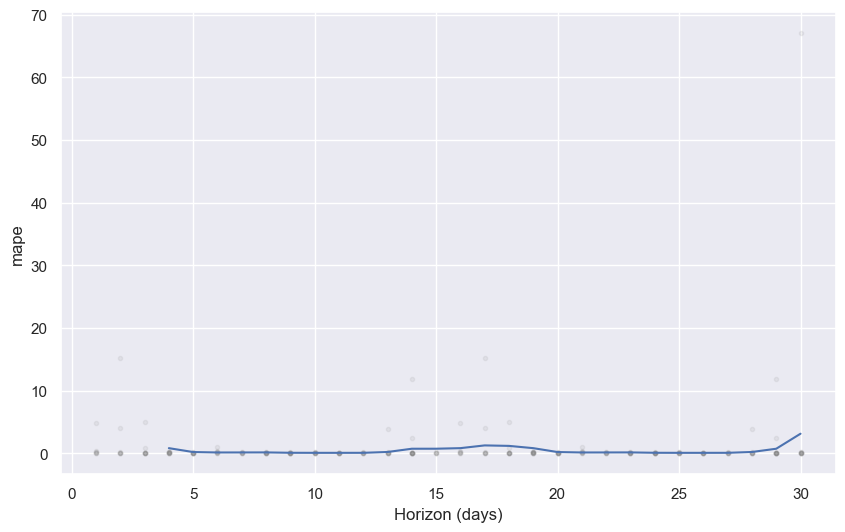

In [78]:
df_performance_visual = plot_cross_validation_metric(df_cv, metric = "mape")